In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

In [3]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_picontrol_dict
model_run_cdr_pulse_dict = utils.model_run_cdr_pulse_dict
model_run_1pct1000gtc_dict = utils.model_run_1pct_1000gtc_dict
model_run_hist_co2_dict = utils.model_run_hist_co2_dict

In [4]:
A = utils.A
ds_out = utils.ds_out

In [5]:
tas_co2_1pct1000gtc = {}
tas_hist = {}
tas_1pct = {}

for m in model_run_1pct_dict.keys():
    tas_1pct[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_1pct[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_1pct[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_1pct[m] = tas_1pct[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_1pct[m] = utils._regrid_ds(tas_1pct[m], ds_out)
    
    
for m in model_run_1pct1000gtc_dict.keys():
    tas_co2_1pct1000gtc[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct1000gtc_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_1pct1000gtc[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_1pct1000gtc[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_1pct1000gtc[m] = tas_co2_1pct1000gtc[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_1pct1000gtc[m] = utils._regrid_ds(tas_co2_1pct1000gtc[m], ds_out)

for m in model_run_hist_co2_dict.keys():
    tas_hist[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_hist_co2_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_hist[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_hist[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_hist[m] = tas_hist[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_hist[m] = utils._regrid_ds(tas_hist[m], ds_out)

    

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter 

In [6]:
def month_weighting(dict_of_datasets):
    for m1 in dict_of_datasets.keys():
        if len(dict_of_datasets[m1]['time']) > 3000:  #hack to get the time stamping to work, should find better fix
            periods = 3000
        else:
            periods = len(dict_of_datasets[m1]['time'])

        times = pd.date_range('1850', periods= periods, freq='MS')
        weights = times.shift(1, 'MS') - times
        weights = xr.DataArray(weights, [('time', dict_of_datasets[m1]['time'][:periods].values)]).astype('float')
        dict_of_datasets[m1] = (dict_of_datasets[m1] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')
        dict_of_datasets[m1]['year'] = dict_of_datasets[m1]['year'] - dict_of_datasets[m1]['year'][0]

In [7]:
month_weighting(tas_co2_1pct1000gtc)
month_weighting(tas_1pct)
month_weighting(tas_hist)

In [8]:
for m in tas_1pct.keys():
    tas_1pct[m] = tas_1pct[m].drop('height')
for m in tas_co2_1pct1000gtc.keys():
    tas_co2_1pct1000gtc[m] = tas_co2_1pct1000gtc[m].drop('height')
    
for m in tas_hist.keys():
    tas_hist[m] = tas_hist[m].drop('height')

In [9]:
ds_tas_1pct = xr.concat([tas_1pct[m] for m in tas_1pct.keys()], pd.Index([m for m in tas_1pct.keys()], name='model'), coords='minimal')
ds_tas_co2_1pct1000gtc = xr.concat([tas_co2_1pct1000gtc[m] for m in tas_co2_1pct1000gtc.keys()], pd.Index([m for m in tas_co2_1pct1000gtc.keys()], name='model'), coords='minimal')
ds_tas_hist = xr.concat([tas_hist[m] for m in tas_hist.keys()], pd.Index([m for m in tas_hist.keys()], name='model'), coords='minimal')


In [83]:
ds_raw = xr.concat([ds_tas_co2_1pct1000gtc, ds_tas_1pct, 
                   # ds_tas_hist
                   ], pd.Index(['1000gtc','1pct',
                              #  'hist_co2'
                               ], name='experiment'), coords='minimal')


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


In [84]:
models = ['ACCESS', 'CANESM5_r1p1', 'GFDL', 'MIROC',
       'NORESM2', 'UKESM1_r1'] #we only will look at one of each model

# Method 1: Hawkins 2009

## 1pct and 1pct1000PgC

In [85]:
ds_raw_1pcts = ds_raw.where(ds_raw.model.isin(models), drop = True).weighted(A).mean(dim = ['lat','lon'])

In [86]:
ds_poly = ds_raw_1pcts.polyfit('year', 4)
ds_fit= xr.polyval(ds_raw_1pcts.year, ds_poly)['tas_polyfit_coefficients']


In [87]:
ds_ref = ds_fit.isel(year = 0)

In [88]:
ds_residual = ds_raw_1pcts - ds_fit - ds_ref

In [89]:
ds_intern_var = ds_residual.var(dim = ['year','experiment']).mean(dim = 'model')

In [90]:
ds_model_var = (ds_fit.var(dim = ['model'])).mean(dim = 'experiment')

In [91]:
ds_scen_var = (ds_fit.mean(dim = ['model'])).var(dim = ['experiment'])

In [92]:
mean_change = ds_fit.mean(dim = ['model','experiment'])

In [93]:
ds_var = xr.concat([ds_intern_var['tas'], ds_model_var, ds_scen_var], pd.Index(['internal_var','model_var','scenario_var'], name = 'variance'), coords = 'minimal')

In [94]:
frac_uncert = (1.65*(np.sqrt(ds_var)))/mean_change

(0.0, 150.0)

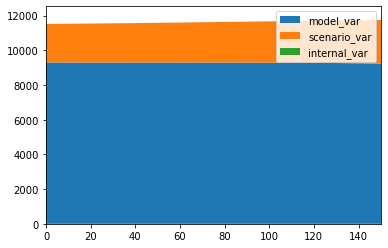

In [97]:
plt.stackplot(ds_var['year'], 
              ds_var.sel(variance = 'model_var'),
              ds_var.sel(variance = 'scenario_var'),
              ds_var.sel(variance = 'internal_var'),
              labels = ['model_var', 'scenario_var','internal_var']);
plt.legend()
plt.xlim(0,150)

(0.0, 150.0)

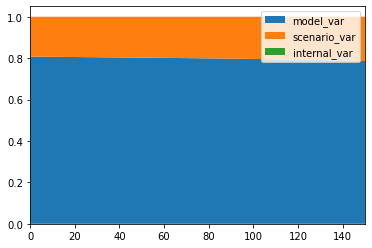

In [95]:
plt.stackplot(ds_var['year'], 
              ds_var.sel(variance = 'model_var')/ds_var.sum('variance'),
              ds_var.sel(variance = 'scenario_var')/ds_var.sum('variance'),
              ds_var.sel(variance = 'internal_var')/ds_var.sum('variance'),
              labels = ['model_var', 'scenario_var','internal_var']);
plt.legend()
plt.xlim(0,150)

mean_var = ds_var.weighted(A).mean(dim = ['lat','lon'])
mean_frac = frac_uncert.weighted(A).mean(dim = ['lat','lon'])

mean_frac = frac_uncert.weighted(A).mean(dim = ['lat','lon'])

In [69]:
ds_var.to_netcdf('Outputs/variance.nc')

mean_var.to_netcdf('Outputs/mean_variance.nc')

mean_frac.to_netcdf('Outputs/mean_frac_uncert.nc')

In [70]:
frac_uncert.to_netcdf('Outputs/frac_uncert.nc')

## Historical Only

In [211]:
ds_poly_hist = ds_tas_hist.polyfit('year', 4)
ds_fit_hist= xr.polyval(ds_tas_hist.year, ds_poly_hist)['tas_polyfit_coefficients']


In [212]:
ds_ref_hist = ds_tas_hist.isel(year = 0)

In [216]:
ds_residual_hist = ds_tas_hist - ds_fit_hist - ds_ref_hist

In [217]:
ds_intern_hist = ds_residual_hist.var(dim = ['model']).mean(dim = 'model')

In [219]:
ds_intern_hist.to_netcdf('Outputs/hist_variance.nc')

In [218]:
ds_intern_hist.weighted(A).mean(dim = ['lat','lon']).to_netcdf('Outputs/hist_mean_variance.nc')

In [221]:
## realization spread

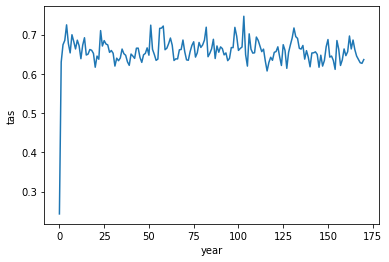

In [227]:
ds_residual_hist.std('model').weighted(A).mean(dim = ['lat','lon'])['tas'].plot()

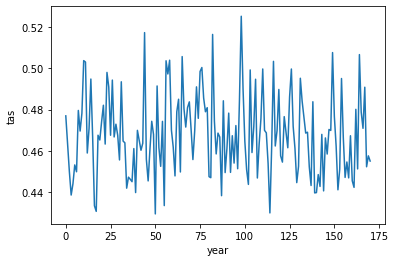

In [226]:
ds_tas_hist.std('model').weighted(A).mean(dim = ['lat','lon'])['tas'].plot()

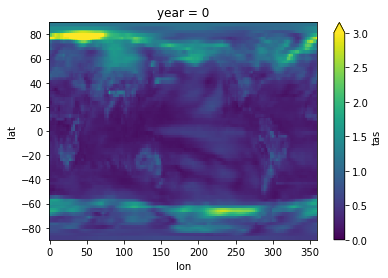

In [230]:
ds_tas_hist.std('model')['tas'].isel(year = 0).plot(vmin = 0, vmax = 3)

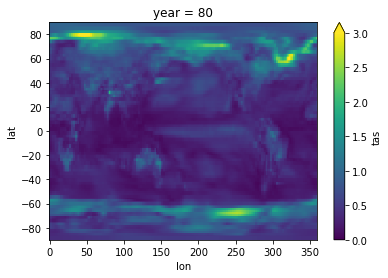

In [231]:
ds_tas_hist.std('model')['tas'].isel(year = 80).plot(vmin = 0, vmax = 3)

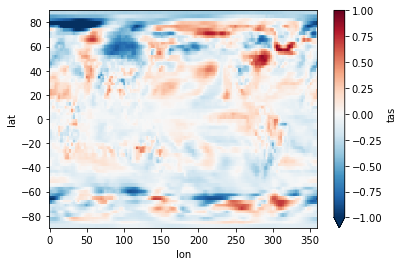

In [233]:
(ds_tas_hist.std('model')['tas'].isel(year = 80) - 
ds_tas_hist.std('model')['tas'].isel(year = 0)).plot(vmin = -1, vmax = 1, cmap = 'RdBu_r')

# Method 2: Leduc

In [12]:
ds_raw_sel = ds_raw.where(ds_raw.model.isin(models), drop = True)

In [13]:
ds_raw_sel = ds_raw_sel.weighted(A).mean(dim = ['lat','lon'])

In [14]:
ds_poly = ds_raw_sel.polyfit('year', 4)
ds_fit= xr.polyval(ds_raw_sel.year, ds_poly)['tas_polyfit_coefficients']


In [15]:
ds_init = ds_fit.isel(year = 0)

In [16]:
ds_resid = ds_raw_sel - ds_init - ds_fit

In [17]:
ds_intern_var = (ds_resid['tas'].var(dim = 'year')).mean(dim = 'model')

In [18]:
ds_model_var = ds_fit.var(dim = 'model')

In [19]:
ds_var = ds_intern_var + ds_model_var

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


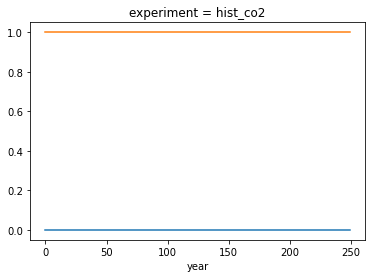

In [20]:
(ds_intern_var.sel(experiment = 'hist_co2')/
    ds_var.sel(experiment = 'hist_co2')).plot()

(ds_model_var.sel(experiment = 'hist_co2')/
    ds_var.sel(experiment = 'hist_co2')).plot()

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


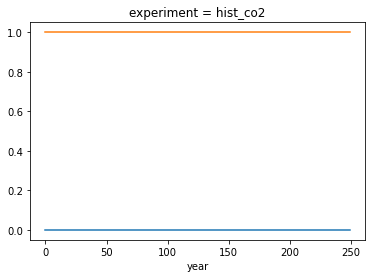

In [51]:
(ds_intern_var.sel(experiment = 'hist_co2').weighted(A).mean(dim = ['lat','lon'])/
    ds_var.sel(experiment = 'hist_co2').weighted(A).mean(dim = ['lat','lon'])).plot()

(ds_model_var.sel(experiment = 'hist_co2').weighted(A).mean(dim = ['lat','lon'])/
    ds_var.sel(experiment = 'hist_co2').weighted(A).mean(dim = ['lat','lon'])).plot()

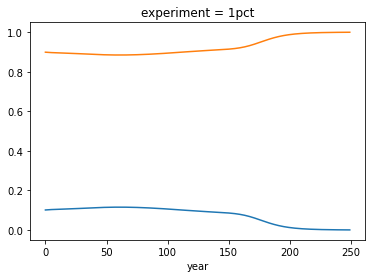

In [53]:
(ds_intern_var.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon'])/
    ds_var.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon'])).plot()

(ds_model_var.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon'])/
    ds_var.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon'])).plot()

# Old

In [3]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [4]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_mean_ds = xr.concat([G_mean_ds, -G_CDR_mean_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

In [5]:
G_ds.name = 'G[tas]'
G_mean_ds.name = 'G[tas]'

In [6]:
G_ds = G_ds.rename({'year':'s'})
G_mean_ds = G_mean_ds.rename({'year':'s'})

## Convolution

In [1]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

NameError: name 'xr' is not defined

## CMIP6 1pct

In [8]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Emissions profile

In [9]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## PiCtrl

In [15]:
ds_pictrl = xr.open_dataset('Outputs/ds_pictrl.nc4')

# Settings and Define our Model Weights

In [10]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

pictrl_model_weights = utils.pictrl_model_weights

In [11]:
type_color = utils.type_color

In [12]:
A = utils.A

In [13]:
proper_names = utils.proper_names

# Significance and SNR tests

## Significance level of pattern response


In [17]:
#group the picontrol data by decade
ds_pictrl['decade'] = ((ds_pictrl['year'] - ds_pictrl['year'][0])/20).astype('int')
decadal_pictrl_ds = ds_pictrl.groupby('decade').mean(dim = 'year').sel(decade = slice(0,16))
decadal_pictrl_ds = decadal_pictrl_ds - decadal_pictrl_ds.weighted(A).mean(dim = ['lat','lon']) #create the pattern (anomaly) of temperature change

In [18]:
#create a matrix of the difference between all pictrl decadal means (15x15)
decadal_pictrl_dict = {}
for i in np.arange(0,16):
    decadal_pictrl_dict[i] = decadal_pictrl_ds['tas'].sel(decade = i) - decadal_pictrl_ds['tas'] 

In [19]:
#take the 95th percentile (abs value) to show the extreme of inter-decadal variability for each model
decadal_pictrl= xr.concat([decadal_pictrl_dict[m] for m in decadal_pictrl_dict.keys()], pd.Index([m for m in decadal_pictrl_dict.keys()], name='init_decade'), coords='minimal')
decadal_pictrl = decadal_pictrl.chunk(dict(init_decade=-1)).chunk(dict(decade=-1))
decadal_95th_pct = decadal_pictrl.quantile(0.95, dim = ['init_decade','decade'])
decadal_95th_pct = np.abs(decadal_95th_pct)

In [20]:
#change our G to units of degrees C by multiplying by the initial forcing
G_decadal_ds = G_ds * 100

#group the G data by decade
G_decadal_ds['decade'] = ((G_decadal_ds['s'] - G_decadal_ds['s'][0])/20).astype('int')
G_decadal_ds = G_decadal_ds.groupby('decade').mean(dim = 's').sel(decade = slice(0,10))
G_decadal_ds = G_decadal_ds - G_decadal_ds.mean(dim = ['lat','lon']) #create the pattern (anomaly) of temperature change

In [21]:
#create a matrix of the difference between all pictrl decadal means (15x15)
G_decadal_dict = {}
for i in np.arange(0,10):
    G_decadal_dict[i] = G_decadal_ds.sel(decade = i) - G_decadal_ds

In [22]:
#take the 95th percentile (abs value) to show the extreme of inter-decadal variability for each model
G_decadal= xr.concat([G_decadal_dict[m] for m in G_decadal_dict.keys()], pd.Index([m for m in G_decadal_dict.keys()], name='init_decade'), coords='minimal')
G_decadal = G_decadal.chunk(dict(init_decade=-1)).chunk(dict(decade=-1))
G_decadal_95th_pct = G_decadal.quantile(0.95, dim = ['init_decade','decade'])
G_decadal_95th_pct = np.abs(G_decadal_95th_pct)

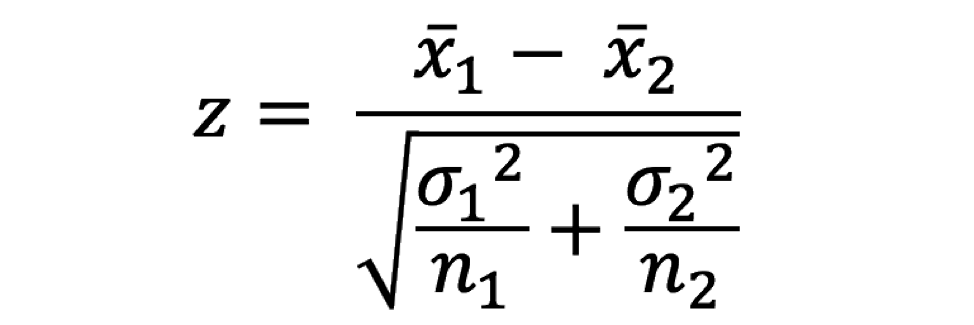

## Test the variability in G vs. internal variability 
(if z test statistic is greater than the significance level, then the variability of G is NOT equal to that of internal variability and is significant)

In [23]:
def z_test(ds_x1, ds_x2, sig_val):
    '''selecting one model type for each ds'''
    z = (ds_x1.mean(dim = ['init_decade','decade']) - ds_x2.mean(dim = ['init_decade','decade']))/(
        np.sqrt((ds_x1.std(dim = ['init_decade','decade'])/(len(ds_x1['decade'])+len(ds_x1['init_decade']))) + 
               (ds_x2.std(dim = ['init_decade','decade'])/(len(ds_x2['decade'])+len(ds_x2['init_decade'])))))
    sig = np.abs(z).where(np.abs(z) > sig_val, drop = True)
    return(z, sig)

In [24]:
sig_val = 1.96
z = {}
sig = {}
for m in ['UKESM1_r1', 'MIROC', 'NORESM2', 'ACCESS', 'GFDL', 'CANESM5_r1p2']:
    z[m], sig[m] = z_test(decadal_pictrl.sel(model = m), G_decadal.mean(dim = ['pulse_type']).sel(model = m), sig_val)

## Significance test of the pattern change of temperature in 1pct vs. internal variability

In [25]:
pattern_1pct_decadal_ds = conv_ds.sel(experiment = '1pct')
#group the 1pct temp change data by decade
pattern_1pct_decadal_ds['decade'] = ((pattern_1pct_decadal_ds['s'] - pattern_1pct_decadal_ds['s'][0])/20).astype('int')
pattern_1pct_decadal_ds = pattern_1pct_decadal_ds.groupby('decade').mean(dim = 's').sel(decade = slice(0,10))
pattern_1pct_decadal_ds = pattern_1pct_decadal_ds - pattern_1pct_decadal_ds.mean(dim = ['lat','lon']) #create the pattern (anomaly) of temperature change

In [26]:
#create a matrix of the difference between all pictrl decadal means (15x15)
pattern_1pct_decadal_dict = {}
for i in np.arange(0,10):
    pattern_1pct_decadal_dict[i] = pattern_1pct_decadal_ds.sel(decade = i) - pattern_1pct_decadal_ds

In [27]:
#take the 95th percentile (abs value) to show the extreme of inter-decadal variability for each model
pattern_1pct_decadal= xr.concat([pattern_1pct_decadal_dict[m] for m in pattern_1pct_decadal_dict.keys()], pd.Index([m for m in pattern_1pct_decadal_dict.keys()], name='init_decade'), coords='minimal')
pattern_1pct_decadal = pattern_1pct_decadal.chunk(dict(init_decade=-1)).chunk(dict(decade=-1))
pattern_1pct_decadal_95th_pct = pattern_1pct_decadal.quantile(0.95, dim = ['init_decade','decade'])
pattern_1pct_decadal_95th_pct = np.abs(pattern_1pct_decadal_95th_pct)

In [28]:
sig_val = 1.96
z_1pct = {}
sig_1pct = {}
for m in ['UKESM1_r1', 'MIROC', 'NORESM2', 'ACCESS', 'GFDL', 'CANESM5_r1p2']:
    z_1pct[m], sig_1pct[m] = z_test(decadal_pictrl.sel(model = m), pattern_1pct_decadal.mean(dim = ['pulse_type']).sel(model = m), sig_val)

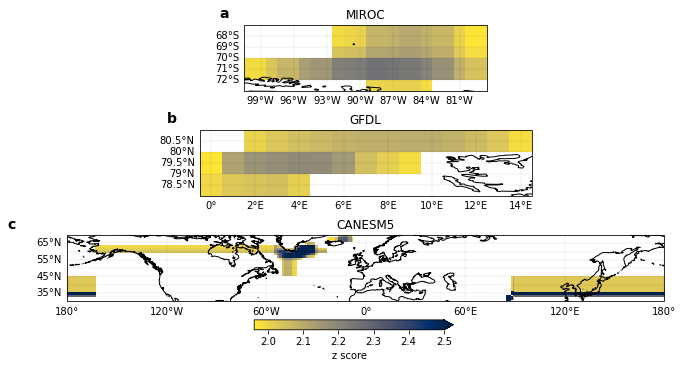

In [77]:
fig, axes = plt.subplots(3,1, subplot_kw = {'projection':ccrs.PlateCarree()}, figsize = [10,5], constrained_layout = True)
idx_range = np.arange(0,7)
idx_range = iter(idx_range)
for m in ['UKESM1_r1', 'MIROC', 'NORESM2', 'ACCESS', 'GFDL', 'CANESM5_r1p2']:
    if sig_1pct[m].shape > (0,0):
        idx = next(idx_range)
        ax = axes[idx]
        #z_1pct[m].plot(ax = ax, cmap = 'RdBu', transform = ccrs.PlateCarree())
        if idx == 2:
            cs = sig_1pct[m].plot(ax = ax, transform = ccrs.PlateCarree(), vmax = 2.5, vmin = 1.96, add_colorbar = True, cmap = 'cividis_r',
                                  cbar_kwargs = {'label':'z score', 'orientation':'horizontal'})
        else:
            cs = sig_1pct[m].plot(ax = ax, transform = ccrs.PlateCarree(), vmax = 2.5, vmin = 1.96, add_colorbar = False, cmap = 'cividis_r')
        ax.set_title(proper_names[m])
        
        #lat lon marking
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
        #gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
        #ax.set_extent(plotting.lat_lon)
        gl.right_labels = gl.top_labels = False

        #label = next(alpha_labels)
        #ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)


        ax.coastlines()
#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in axes.ravel():
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

        
plt.savefig('figures/paper/supp_significance.png', dpi = 350, bbox_inches = 'tight')

## Signal to Noise

In [29]:
noise = np.abs(decadal_pictrl).mean(dim = ['decade', 'init_decade']).weighted(pictrl_model_weights).mean(dim = 'model')

In [30]:
signal = (G_ds * 100).mean(dim = ['s','pulse_type']).weighted(G_model_weights).mean(dim = 'model')

In [31]:
snr = signal/noise

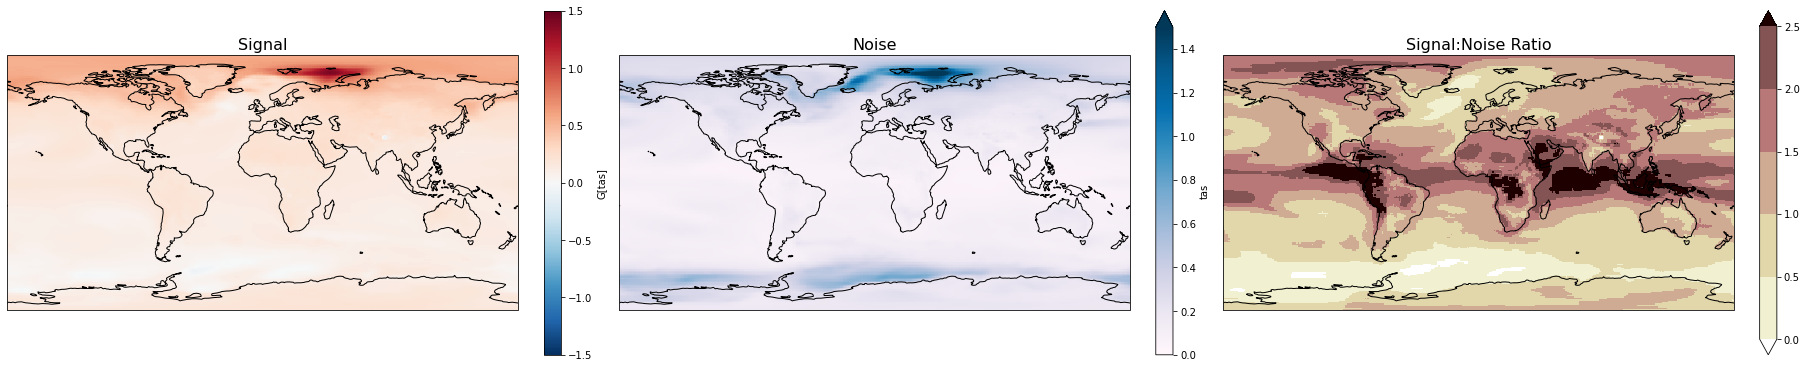

In [47]:
## Averaged around a given year
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = [25,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':r'Multi-Model Mean Temperature Trend ($\degree$C)'}}
(signal).plot(ax = ax1,
    transform = ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5, add_colorbar = True, cbar_kwargs= cbar_arg[0])

cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Multi-Model Mean $\sigma$ Trend ($\degree$C)'}}
(noise).plot(ax = ax2,
    transform = ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0, vmax = 1.5, add_colorbar = True, cbar_kwargs= cbar_arg[0])

cbar_arg= {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Absolute value of signal to noise ratio'}}
(snr).plot(ax = ax3,
    transform = ccrs.PlateCarree(), levels = np.arange(0,3.,0.5), cmap = 'pink_r', add_colorbar = True, cbar_kwargs= cbar_arg[0] )

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

ax1.set_title('Signal', fontsize = 16)
ax2.set_title('Noise', fontsize = 16)
ax3.set_title('Signal:Noise Ratio', fontsize = 16)

#ax1.text(x = -240, y = 0.1, s = f'Averaged\naround\n{t} Years', fontsize = 16)
plt.savefig(f'figures/paper/supp_signal_to_noise.png', bbox_inches = 'tight', dpi = 350)

## 1 sigma plot for patterns

In [32]:
pattern_1pct_decadal_1sigma = pattern_1pct_decadal.quantile(0.68, dim = ['init_decade','decade'])
pattern_1pct_decadal_1sigma = np.abs(pattern_1pct_decadal_1sigma)

In [33]:
decadal_pictrl_1sigma = decadal_pictrl.quantile(0.68, dim = ['init_decade','decade'])
decadal_pictrl_1sigma = np.abs(decadal_pictrl_1sigma)

# Pattern anomaly testing

In [34]:
dif_yr = 10
ds_dif_mean = ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model')
spatial_pattern_1pct = (((ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's')-ds_dif_mean.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's')) - 
                        ((ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's')-ds_dif_mean.sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model')['tas']
spatial_pattern_em = (((conv_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's')-conv_mean_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's'))/conv_mean_ds.sel( s = slice(70-dif_yr, 70+dif_yr))).mean(dim = 's') - 
                      ((conv_ds.sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's')-conv_mean_ds.sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's'))/conv_mean_ds.sel( s = slice(20-dif_yr, 20+dif_yr)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

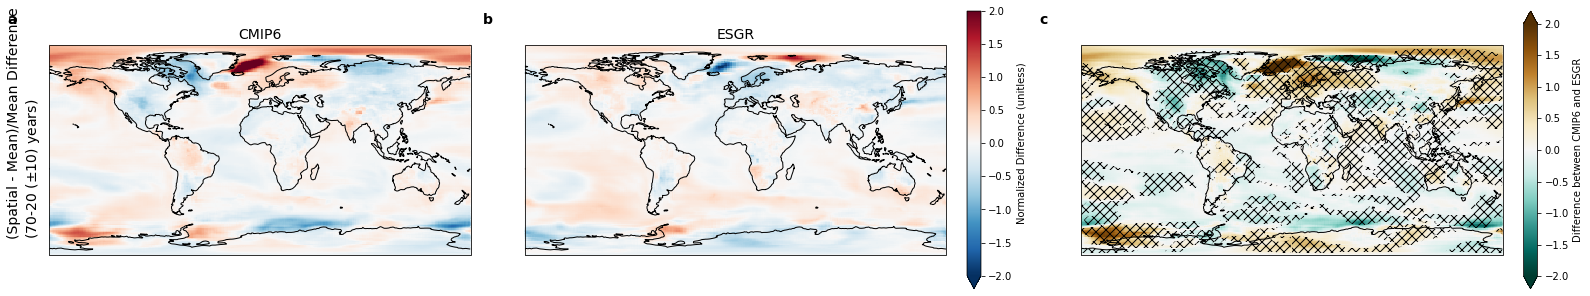

In [79]:
## FIGURE 3 FIXED
cmap = cmo.matter
levels = np.arange(0,6.25,0.25)
fig, ([ax1, ax2, ax3])= plt.subplots(1,3, figsize = [22,4], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
vmin = -2
vmax = 2
#### 1pct model ###

### spatial pattern
spatial_pattern_1pct.sel(experiment = '1pct').plot(ax = ax1, vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.text(x = -0.1, y = .1, s = f'(Spatial - Mean)/Mean Difference\n(70-20 ($\pm 10$) years)', rotation = 90, fontsize = 14, transform=ax1.transAxes)
ax1.set_title('CMIP6', fontsize = 14)


### Emulator ###

### spatial pattern
spatial_pattern_em.sel(experiment = '1pct').plot(ax = ax2, vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'Normalized Difference (unitless)'})
#sig_dif_full_mean.plot.contourf(ax = ax2, hatches = ['', '\\\\////'], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)

ax2.coastlines()
ax2.set_title('ESGR', fontsize = 14)

### Difference ###

### spatial pattern
(spatial_pattern_1pct - spatial_pattern_em).sel(experiment = '1pct').plot(ax = ax3, vmax = vmax, vmin = vmin, cmap = 'BrBG_r', transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'Difference between CMIP6 and ESGR'})
((spatial_pattern_em.sel(experiment = '1pct') >= 0) & (spatial_pattern_1pct.sel(experiment = '1pct') < 0) ).plot.contourf(
    ax = ax3, hatches = ['', '\\\///'], levels = 3, colors = 'none', transform = ccrs.PlateCarree(),  add_colorbar = False)

((spatial_pattern_em.sel(experiment = '1pct') <= 0) & (spatial_pattern_1pct.sel(experiment = '1pct') > 0) ).plot.contourf(
    ax = ax3,hatches = ['', '\\\///'], levels = 3, colors = 'none', transform = ccrs.PlateCarree(),  add_colorbar = False)
ax3.coastlines()
ax3.set_title(None)

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)


plt.savefig(f'figures/paper/figure3_TCRE_pattern_change.png', bbox_inches = 'tight', dpi = 300)